# CSCI-P556: Applied Machine Learning
## Fall 2018
### Assignment #3




In [290]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import warnings

In [2]:
#os.chdir('C:/Users/singh/Documents/Acads/AML/A3/Assignment 3')

### 1. Loading Datasets

In [3]:
#Loading Test Dataset
with open('a3-test.data', 'r') as f:
    data_test = f.readlines()

test_data=[]
for r in data_test:
    row = r.rstrip('\n').rstrip(' ').split(' ')
    test_data.append(row)

test_data = pd.DataFrame(test_data)

#loading Train Dataset
with open('a3-train.data', 'r') as f:
    data_train = f.readlines()
    
train_data=[]
for r in data_train:
    row = r.rstrip('\n').rstrip(' ').split(' ')
    train_data.append(row)
    
train_data = pd.DataFrame(train_data)

#Changing column names
col=[]
for i in range(len(test_data.columns)):
    c='f' + str(int(test_data.columns[i])+1)
    col.append(c)

test_data.columns = col
train_data.columns = col

train_data = train_data.astype('int64')
test_data = test_data.astype('int64')

train_data.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f491,f492,f493,f494,f495,f496,f497,f498,f499,f500
0,485,477,537,479,452,471,491,476,475,473,...,477,481,477,485,511,485,481,479,475,496
1,483,458,460,487,587,475,526,479,485,469,...,463,478,487,338,513,486,483,492,510,517
2,487,542,499,468,448,471,442,478,480,477,...,487,481,492,650,506,501,480,489,499,498
3,480,491,510,485,495,472,417,474,502,476,...,491,480,474,572,454,469,475,482,494,461
4,484,502,528,489,466,481,402,478,487,468,...,488,479,452,435,486,508,481,504,495,511


In [4]:
test_label = pd.read_table('a3-test.labels.txt', header=None, names=['Label'])
train_label = pd.read_table('a3-train.labels.txt', header=None, names=['Label'])


### 2. EDA

In [5]:
#Checking the numbers of each class in train and test
print(train_label['Label'].value_counts())
print(test_label['Label'].value_counts())

 1    1000
-1    1000
Name: Label, dtype: int64
 1    300
-1    300
Name: Label, dtype: int64


Inference: Labels are balanced in both train and test set

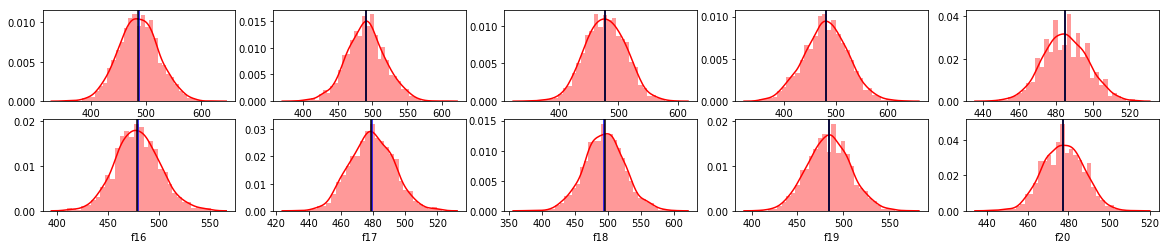

In [303]:
#Checking distribution of data
for i,c in zip(range(len(train_data.columns[0:10])),train_data.columns[10:20]):
    fig = plt.figure(1, figsize=(20,40))
    fig.add_subplot(20,5,i+1)
    sns.distplot(train_data[c], color='red', axlabel=c)
    plt.axvline(train_data[c].mean(), c='blue')
    plt.axvline(train_data[c].median(), c='black')

Inference: Most of the features resemble a normal distribution with median and mean being close to each other

In [6]:
#checking number of NAs in the test and train datasets
print('Columns with NAs and their quantity in train dataset:')
for c in train_data.columns:
    if train_data[c].isna().sum() > 0:
        print(c,train_data[c].isna().sum())

print('Columns with NAs and their quantity in test dataset:')
for c in test_data.columns:
    if test_data[c].isna().sum() > 0:
        print(c,test_data[c].isna().sum())
        

Columns with NAs and their quantity in train dataset:
Columns with NAs and their quantity in test dataset:


Inference: There are no NAs in the data. Therefore, we do not have to make any imputations

In [7]:
#Checking if any column has any negative value
for c in train_data.columns:
    if train_data[c].any() < 0:
        print('column in train dataset which have negative values:',c)
        
for c in test_data.columns:
    if test_data[c].any() < 0:
        print('column in test dataset which have negative values:', c)
        
#None of the columns in test and train datasets have negative values

Inference: There are no negative values in the train and test dataset

In [8]:
#checking columns with number  of distinct values <5
for c in train_data.columns:
    if len(train_data[c].unique()) <= 5:
        print(c,train_data[c].unique())
        
for c in test_data.columns:
    if len(test_data[c].unique()) <= 5:
        print(c,test_data[c].unique())
        
#Can we treat these as categorical values

f91 [476 477 475 478 474]
f277 [476 475 477 478 474]
f424 [476 475 477 474 478]
f91 [476 475 477 478 474]
f277 [476 477 475 478 474]
f405 [476 478 477 475 479]
f424 [477 476 475 478]


Inference: There are 3 features in train dataset with less than 5 unique values. These values can be treated as categorical values depending on the kinf of values but since the values in this features are comparable to that of other features, I'm going ahead with treating them as continuous variables

In [9]:
#Checking columns with unique identifiers
for c in train_data.columns:
    if len(train_data[c].unique()) == len(train_data[c]):
        print(c)
        
#No column with unique identifiers

Inference: There are no columns in train dataset with unique identifiers

Number of outliers in column f11 : 15
Number of outliers in column f12 : 25
Number of outliers in column f13 : 12
Number of outliers in column f14 : 19
Number of outliers in column f15 : 13
Number of outliers in column f16 : 22
Number of outliers in column f17 : 11
Number of outliers in column f18 : 17
Number of outliers in column f19 : 12
Number of outliers in column f20 : 9


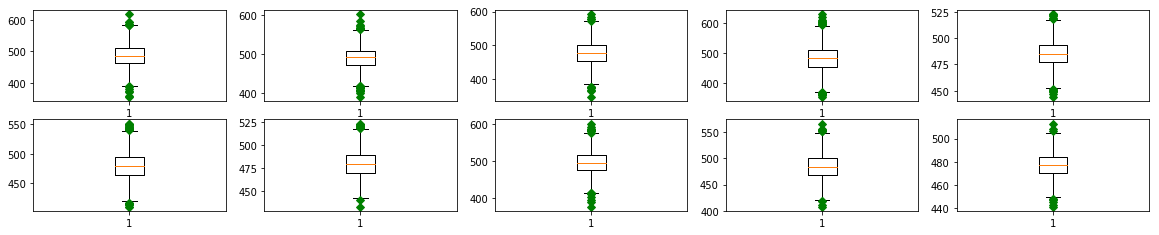

In [304]:
warnings.filterwarnings('ignore')
#Checking for number of outliers in each column
for i,c in zip(range(len(train_data.columns[0:10])),train_data.columns[10:20]):
    iqr = train_data[c].quantile(0.75)-train_data[c].quantile(0.25)
    fig = plt.figure(1, figsize=(20,40))
    ub = train_data[train_data[c]>train_data[c].quantile(0.75)+1.5*iqr][c].count()
    lb = train_data[train_data[c]<train_data[c].quantile(0.25)-1.5*iqr][c].count()
    if ub+lb > 0 and ub+lb < 100:
        fig.add_subplot(20,5,i+1)
        plt.boxplot(train_data[c], 0, 'gD')
        print('Number of outliers in column',c,':',ub+lb)        

Above code prints the names of columns and the number of outliers* in that column if the number of outliers are <5% of the total number of values. Since by this definition most of the columns have outlier, I have not deicded to treat these because of following reasons-
1. We do know the physical significance of the values, it might be that columns values might be an outliers according to the definition of outlier defined by us but might be a meaningful value
2. Treating outliers in all the column might decrease the bias in the data, leading to overfitting the training data
3. The density plots seem smooth with no outliers seeming obvious

*outlier is a point which falls more than 1.5 times the interquartile range above the third quartile or below the first quartile

In [323]:
#Checking correlation between variables
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, t):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[au_corr>t]

t = 0.5
print('Number of pairs with correlation greater than '+str(t))
corr_pairs_df = pd.DataFrame(get_top_abs_correlations(train_data, t), columns=['Correlation'])
corr_f = list(set(corr_pairs_df.index.get_level_values(1)))
train_data_corr = train_data.drop(corr_f, axis=1)
test_data_corr = test_data.drop(corr_f, axis=1)
print(len(corr_pairs_df))
corr_pairs_df

#Choose only one out of highly correlated pairs

Number of pairs with correlation greater than 0.5
47


,,Correlation
f65,f337,0.990429
f443,f473,0.990300
f29,f319,0.989628
f106,f129,0.989410
f154,f434,0.989355
f242,f476,0.989272
f29,f452,0.989168
f282,f434,0.989047
f154,f282,0.988695
f319,f452,0.988690


Inference: There are 47 pairs with correlation greater than 0.5.<br>
One of the features from these pairs has been removed from the original dataset to create a new dataset which excluded the highly correlated pairs

In [11]:
#Function for Normalizing
def normalize(df):
    col_mean = df.mean()
    
    df = df.sub(col_mean)
    
    col_std = df.std()
    
    df = df.div(col_std)
    
    return df

In [28]:
#Normalizing training and testing datasets
train_data_norm = normalize(train_data)
test_data_norm = normalize(test_data)

### Logistic Regression

In [29]:
#Baseline Logistic Regression model
LRmodel = LogisticRegression()
LRmodel.fit(train_data_norm, train_label['Label'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [207]:
#Calculate the training score 
train_score = LRmodel.score(train_data_norm, train_label)*100
print('Baseline Logistic Regression accuracy on train data:',train_score)

Baseline Logistic Regression accuracy on train data: 74.05000000000001


In [208]:
#Using the LRmodel to predict dependent variable values using test data
LRpredict = LRmodel.predict(test_data_norm)

In [209]:
#Accuracy of model
accuracy_score = metrics.accuracy_score(test_label['Label'], LRpredict)*100
print('Baseline Logistic Regression accuracy on test data:',accuracy_score)

Baseline Logistic Regression accuracy on test data: 57.99999999999999


In [33]:
#Normalizing training and testing datasets after removing one of highly correlated pairs
train_data_corr_norm = normalize(train_data_corr)
test_data_corr_norm = normalize(test_data_corr)

In [34]:
#Training Logistic Regression model after removing one of the highly correlated pair
LRmodel2 = LogisticRegression(penalty='l2', C=0.1)
LRmodel2.fit(train_data_corr_norm, train_label['Label'])

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
#Using the LRmodel2 to predict dependent variable values using test data
LRpredict2 = LRmodel2.predict(test_data_corr_norm)

In [211]:
#Accuracy of model LRmodel2
accuracy_score2 = metrics.accuracy_score(test_label['Label'], LRpredict2)*100
print('Accuracy of Logistic Regression Model which is trained after excluding correlated pairs:',accuracy_score2)

##Accuracy decreases

Accuracy of Logistic Regression Model which is trained after excluding correlated pairs: 56.00000000000001


maximum accuracy of 62.83333333333333 is obtained for k= 4


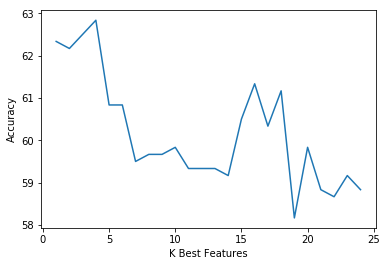

In [340]:
from sklearn.feature_selection import SelectKBest
#Selecting K Best Features
kbar=range(1,25,1)
max_acc=0
best_k=0
acc_score_kbest=[]
for i in kbar:
    kbest_features = SelectKBest(k=i)
    train_data_norm_kbest = kbest_features.fit_transform(train_data_norm, train_label['Label'])
    test_data_norm_kbest = kbest_features.transform(test_data_norm)

    #Implementing Logistic Regression using the best features obtained above
    lr_kbest = LogisticRegression(penalty='l2', C=0.1)
    lr_kbest.fit(train_data_norm_kbest, train_label['Label'])

    pred_lr_kbest = lr_kbest.predict(test_data_norm_kbest)

    #Checking accuracy
    acc = metrics.accuracy_score(test_label['Label'], pred_lr_kbest)*100
    if acc>max_acc:
            max_acc=acc
            best_k=i
            #best_k_features = SelectKBest(k=i)
    acc_score_kbest.append(acc)
    
plt.plot(kbar,acc_score_kbest)
plt.xlabel('K Best Features')
plt.ylabel('Accuracy')
print('maximum accuracy of',max_acc,'is obtained for k=',best_k)



'SelectKBest' feature selection method is used  to select K best features from the dataset. Best accuracy of 62.83% is obtained at k=4

In [337]:
#Implementing PCA
# n_pca = range(1,500)
# max_acc=0
# best_n=0
# acc_score_nbest=[]
# for n in n_pca:
n=1
pca=PCA(n_components=n)
train_data_pca = pca.fit_transform(train_data_norm)
test_data_pca = pca.fit_transform(test_data_norm)

#Logistic Regression using PCA features
lr_pca = LogisticRegression()
lr_pca.fit(train_data_pca,train_label['Label'])
pred_lr_pca = lr_pca.predict(test_data_pca)

#Checking accuracy score
acc = metrics.accuracy_score(test_label['Label'], pred_lr_pca)*100
#if acc>max_acc:
max_acc=acc
best_n=n
#best_k_features = SelectKBest(k=i)
explained_variance = pca.explained_variance_ratio_
exp_var = explained_variance.sum()
acc_score_nbest.append(acc)
    
#plt.plot(n_pca,acc_score_nbest)
print('maximum accuracy of',max_acc,'is obtained for number of components=',best_n)
print('explained variance using', best_n, 'component(s) from PCA:',exp_var)

#The maximum accuracy is obtained by Logistic Regression Model trained using just the first principal component
#even though the variance explained is very less

maximum accuracy of 59.833333333333336 is obtained for number of components= 1
explained variance using 1 component(s) from PCA: 0.014780644251246053


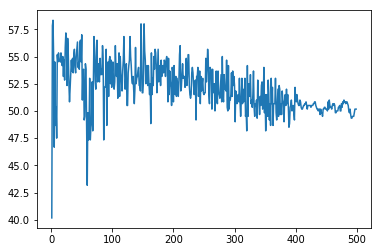

In [341]:
#Using Recursive feature elimination to search for beast features
rfe_model = LogisticRegression()
rfe = RFE(rfe_model, 20)
rfe = rfe.fit(train_data_norm, train_label['Label'])
rfe_cols = train_data_norm.columns[rfe.support_]
train_data_norm_rfe = train_data_norm[rfe_cols]
test_data_norm_rfe = test_data_norm[rfe_cols]

In [342]:
LR_model_rfe = LogisticRegression(penalty='l2', C=0.1)
LR_model_rfe.fit(train_data_norm_rfe,train_label['Label'])
pred_lr_rfe = LR_model_rfe.predict(test_data_norm_rfe)

acc_score_rfe = metrics.accuracy_score(test_label['Label'],pred_lr_rfe)*100
print('Accuracy obtained using Recrsive Feature Elimination:',acc_score_rfe)

Accuracy obtained using Recrsive Feature Elimination: 58.166666666666664


Logistic Regression<br>
Conclusion: Maximum accuracy obtained using Logistic Regression is 62.5%, which is obtained by selecting best 3 features from the dataset

### Random Forest Classifier

In [144]:
##Implementing baseline Random Forest Classifier
RFmodel = RandomForestClassifier(random_state=0, n_jobs=-1)

RFmodel.fit(train_data_norm, train_label['Label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [228]:
# Applying the full featured classifier to the test data
test_label_RF = RFmodel.predict(test_data_norm)

# Accuracy of full featured model
acc_RF = metrics.accuracy_score(test_label['Label'], test_label_RF)
print('accuracy obtained using baseline RF classifier:',acc_RF*100)

accuracy obtained using baseline RF classifier: 61.83333333333333


In [204]:
#Testing feature importance
n_features=18
rf_imp_features = RFmodel.feature_importances_.argsort()[::-1][:n_features]
print('Important Features obtained from random forest:',rf_imp_features)

train_rf_imp_data = train_data_norm.iloc[:,rf_imp_features]

#Training  RF model on important features
rf_imp = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
rf_imp.fit(train_rf_imp_data, train_label['Label'])

test_rf_imp_data = test_data_norm.iloc[:,rf_imp_features]
test_label_rf_imp = rf_imp.predict(test_rf_imp_data)

acc_rf_imp = metrics.accuracy_score(test_label['Label'], test_label_rf_imp)

print('Accuracy using important features in random forest:',acc_rf_imp*100)

Important Features obtained from random forest: [338 336 241 472 453  48 475 451 442 105 128  64 281 433 208 318 272  89]
Accuracy using important features in random forest: 89.83333333333333


Best values of 'n_features' is obtained using iteration over values of n_iteration<br>
In this tuning best features are selected using the feature importance of Random Forest and another RF model is trained based on only those features. It gives an accuracy score of 89.83%

           Correlation
f337 f65      0.990429
f473 f443     0.990300
f106 f129     0.989410
f242 f476     0.989272
f282 f434     0.989047
f452 f319     0.988690
f337 f242     0.735253
f242 f65      0.734728
f476 f65      0.733741
f337 f476     0.733736
correlation matric of the important features obtained from Random Forest


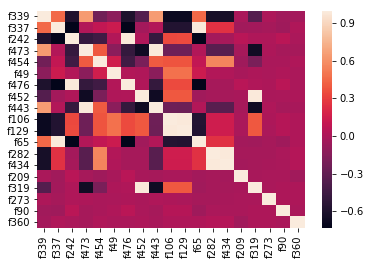

In [234]:
#Correlation between best features obtained from Random Forest
t=0.7
corr_pairs_rf_df = pd.DataFrame(get_top_abs_correlations(train_rf_imp_data, t), columns=['Correlation'])
print(corr_pairs_rf_df)

print('correlation matric of the important features obtained from Random Forest')
sns.heatmap(train_rf_imp_data.corr())


In [232]:
#Removing one of the features which are highly correlated
corr_rf = list(set(corr_pairs_rf_df.index.get_level_values(1)))
train_data_corr_rf = train_rf_imp_data.drop(corr_rf, axis=1)
test_data_corr_rf = test_rf_imp_data.drop(corr_rf, axis=1)
print(corr_pairs_rf_df)
train_data_corr_rf.head()


           Correlation
f337 f65      0.990429
f473 f443     0.990300
f106 f129     0.989410
f242 f476     0.989272
f282 f434     0.989047
f452 f319     0.988690
f337 f242     0.735253
f242 f65      0.734728
f476 f65      0.733741
f337 f476     0.733736


,f339,f337,f473,f454,f49,f452,f106,f282,f209,f273,f90,f360
0,1.315334,1.694319,0.778339,-0.091886,-1.046263,-1.574452,-2.386303,0.729101,0.663140,-0.808347,-1.124771,-0.369948
1,0.283926,-0.113582,-0.346363,-1.501984,0.325489,-0.387693,-0.528321,-0.868928,-2.130989,-0.714431,0.348682,-1.099748
2,-0.716540,-0.151845,0.103518,1.097885,-0.581263,0.367518,0.675652,1.079887,1.221966,-0.503120,-0.820725,-0.588888
3,-1.273500,-0.792741,-0.526316,0.560285,1.022990,-0.603467,1.456004,0.904494,0.973599,2.924817,-0.165857,-0.102355
4,0.087958,-0.917094,0.440928,-0.488476,-1.302014,-0.603467,-0.379682,-0.459677,0.228498,1.116932,1.377761,1.235613


In [235]:
#Training RF model after removing one of highly correlated pairs
rf_imp_corr = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
rf_imp_corr.fit(train_data_corr_rf, train_label['Label'])

test_label_rf_imp_corr = rf_imp_corr.predict(test_data_corr_rf)

acc_rf_imp_corr = metrics.accuracy_score(test_label['Label'], test_label_rf_imp_corr)

print('Accuracy using important features in random forest after removing one of corr pairs:',acc_rf_imp_corr*100)

#Accuracy Decreses by 0.5

Accuracy using important features in random forest after removing one of corr pairs: 87.5


Therefore, accuracy decreses by ~1% on removing one of highly correlated pairs from important features

#### Attempt to find best parameters using Grid Search CV

In [236]:
##Iternation 1
#Defining parameters for Grid Search Cross Validation
parameters_rf = {
                'max_depth': [5,10,15,25,50,100],
                'max_features': [9],
                'n_estimators': [600]
                }

In [237]:
cv_score_rf=GridSearchCV(rf_imp, parameters_rf)

cv_score_rf.fit(train_rf_imp_data, train_label['Label'])

cv_score_rf.best_score_

0.869

In [152]:
cv_score_rf.best_params_

{'max_depth': 10, 'max_features': 9, 'n_estimators': 600}

In [238]:
rf_cv_pred = cv_score_rf.predict(test_rf_imp_data)

acc_rf_cv = metrics.accuracy_score(rf_cv_pred,test_label['Label'])

print('accuracy obtained after first iteration:',acc_rf_cv*100)

accuracy obtained after first iteration: 89.16666666666667


In [343]:
##Iteration 2
#Best max_depth obtained from previous iteration = 10
parameters_rf = {
                'max_depth': [10],
                'max_features': [1,3,6,7,9,10,15],
                'n_estimators': [600]
                }

In [344]:
cv_score_rf=GridSearchCV(rf_imp, parameters_rf)

cv_score_rf.fit(train_rf_imp_data, train_label['Label'])

cv_score_rf.best_score_

0.861

In [345]:
cv_score_rf.best_params_

{'max_depth': 10, 'max_features': 10, 'n_estimators': 600}

In [346]:
rf_cv_pred = cv_score_rf.predict(test_rf_imp_data)

acc_rf_cv = metrics.accuracy_score(rf_cv_pred,test_label['Label'])

print('accuracy obtained after second iteration:',acc_rf_cv*100)

accuracy obtained after second iteration: 88.33333333333333


In [347]:
##Iteration 3
#Best value of 'max_features' obtained from previous iteration = 9
parameters_rf = {
                'max_depth': [10],
                'max_features': [10],
                'n_estimators': list(np.arange(100,1101,100))
                }

In [348]:
cv_score_rf=GridSearchCV(rf_imp, parameters_rf)

cv_score_rf.fit(train_rf_imp_data, train_label['Label'])

cv_score_rf.best_score_

0.864

In [349]:
cv_score_rf.best_params_

{'max_depth': 10, 'max_features': 10, 'n_estimators': 400}

In [350]:
rf_cv_pred = cv_score_rf.predict(test_rf_imp_data)

acc_rf_cv = metrics.accuracy_score(rf_cv_pred,test_label['Label'])

print('accuracy obtained after third iteration:',acc_rf_cv*100)

accuracy obtained after third iteration: 88.33333333333333


The accuracy is lower than the accuracy obtained when choosing original 18 important features. This can be because the best combination of parameters can be choosen by iterating over one parameter at a time.

In [247]:
#Below are the features which are obtained on running multiple iterations of parameters using grid search CV
parameters_rf_best = {
                'max_depth': [25],
                'max_features': [12],
                'n_estimators': [600]
                }

In [248]:
cv_score_rf=GridSearchCV(rf_imp, parameters_rf_best)

cv_score_rf.fit(train_rf_imp_data, train_label['Label'])

cv_score_rf.best_score_

0.863

In [249]:
cv_score_rf.best_params_

{'max_depth': 25, 'max_features': 12, 'n_estimators': 600}

In [307]:
rf_cv_pred = cv_score_rf.predict(test_rf_imp_data)

acc_rf_cv = metrics.accuracy_score(rf_cv_pred,test_label['Label'])

print('accuracy obtained after getting best features from changing all featues in gridsearchCV:',acc_rf_cv*100)

#Best accuracy of 89.1% is obtained using grid search cross validation

accuracy obtained after getting best features from changing all featues in gridsearchCV: 88.66666666666667


### KNN Algorithm

maximum accuracy of 62.5 is obtained for value of k= 6


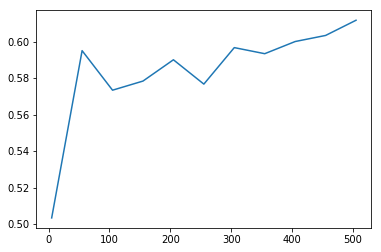

In [309]:
#Baseline KNN for different values of k
k = range(5, 555, 50)
acc_knn=[]
for i in k:
    knn = KNeighborsClassifier(n_neighbors=i)  
    knn.fit(train_data_norm, train_label['Label'])
    pred_knn = knn.predict(test_data_norm)
    acc = metrics.accuracy_score(test_label['Label'], pred_knn)
    if acc>max_acc:
        max_acc=acc
        max_k=i
    acc_knn.append(acc)
    
plt.plot(k,acc_knn)
print('maximum accuracy of', max_acc, 'is obtained for value of k=',max_k)

Baseline KNN Classifier with accuracy of 62.5% is obtained for value of k=6

In [351]:
#applying knn to the best features obtained from random forest classifier
#Testing feature importance
max_acc=0
best_k=0
best_n=0
acc_knn=[]
n_features=range(1,20,1)
for n in n_features:
    rf_imp_features = RFmodel.feature_importances_.argsort()[::-1][:n]
    train_rf_imp_data = train_data_norm.iloc[:,rf_imp_features]
    test_rf_imp_data = test_data_norm.iloc[:,rf_imp_features]

    k = range(1, 25, 1)
    #max_acc=0
    #max_k=0
    for i in k:
        knn = KNeighborsClassifier(n_neighbors=i)  
        knn.fit(train_rf_imp_data, train_label['Label'])
        pred_knn = knn.predict(test_rf_imp_data)
        acc = metrics.accuracy_score(test_label['Label'], pred_knn)
        if acc>max_acc:
            max_acc=acc
            best_k=i
            best_n=n
        acc_knn.append(acc)
    
print('MAX ACCURACY:',max_acc*100)
print('value of k at max acc:',best_k)
print('number of features considered at best accuracy:',best_n)

MAX ACCURACY: 91.66666666666666
value of k at max acc: 6
number of features considered at best accuracy: 13


Applying KNN on the best features obtained from Random Forest Classifier gives a maximum accuracy of 91.6% when 13 features are taken from random forest and value of k=6

max accuracy: 79.5
value of k at max acc: 15


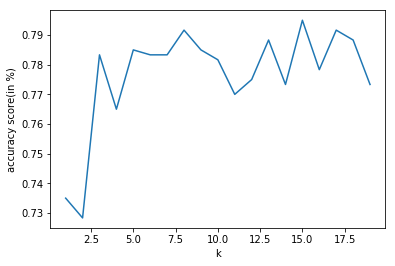

In [201]:
#applying knn t0 the best features obtained from k best features
#Testing feature importance
k = range(1, train_data_norm_kbest.shape[1], 1)
acc_knn=[]
max_acc=0
max_k=0
for i in range(1,train_data_norm_kbest.shape[1]):
    knn = KNeighborsClassifier(n_neighbors=i)  
    knn.fit(train_data_norm_kbest, train_label['Label'])
    pred_knn = knn.predict(test_data_norm_kbest)
    acc = metrics.accuracy_score(test_label['Label'], pred_knn)
    if acc>max_acc:
        max_acc=acc
        max_k=i
    acc_knn.append(acc)
    
plt.plot(k,acc_knn)
plt.xlabel('k')
plt.ylabel('accuracy score(in %)')
print('max accuracy:',max_acc*100)
print('value of k at max acc:',max_k)

Applying KNN on the best K features obtained using 'SelectKBest' feature selection gives a best accuracy of 79.5% for 15 best features

In [180]:
#using knn on principal components
max_acc=0
max_k=0
max_comp=n=0
n_comp = list(np.arange(1,50))
for n in n_comp:
    pca=PCA(n_components=n)
    train_data_knn_pca = pca.fit_transform(train_data_norm)
    test_data_knn_pca = pca.fit_transform(test_data_norm)
    
    for i in range(1,n):
        knn = KNeighborsClassifier(n_neighbors=i)  
        knn.fit(train_data_knn_pca, train_label['Label'])
        pred_knn_pca = knn.predict(test_data_knn_pca)
        acc = metrics.accuracy_score(test_label['Label'], pred_knn_pca)
        if acc>max_acc:
            max_acc=acc
            max_k=i
            max_comp=n
        acc_knn.append(acc)

print('max accuracy:',max_acc*100)
print('value of k at max acc:',max_k)
print('number of components for max acc:',max_comp)
    

max accuracy: 60.66666666666667
value of k at max acc: 12
number of components for max acc: 13


### SVM

In [311]:
#Implementing linear svm
from sklearn.svm import SVC  
svc0 = SVC(kernel='linear')  
svc0.fit(train_data_norm, train_label['Label'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [312]:
#Predicting using linear svm
svc0_pred = svc0.predict(test_data_norm)

acc_svc0 = metrics.accuracy_score(svc0_pred, test_label['Label'])
print('Accuracy using linear SVM:',acc_svc0*100)

Accuracy using linear SVM: 58.5


In [313]:
#Implementing polynomial kernel
for d in range(1, 6):
    svc1 = SVC(kernel='poly', degree=d)
    svc1.fit(train_data_norm, train_label['Label'])

    #Predicting using polynomial kernel
    svc1_pred = svc1.predict(test_data_norm)

    acc_svc1 = metrics.accuracy_score(svc1_pred, test_label['Label'])
    print('Accuracy using polynomial SVM of degree',d,':',acc_svc1*100)
    
##Max accracy is obtained at degree=2

Accuracy using polynomial SVM of degree 1 : 58.166666666666664
Accuracy using polynomial SVM of degree 2 : 58.666666666666664
Accuracy using polynomial SVM of degree 3 : 57.833333333333336
Accuracy using polynomial SVM of degree 4 : 50.33333333333333
Accuracy using polynomial SVM of degree 5 : 50.0


In [314]:
#Implementing gaussian kernel
svc2 = SVC(kernel='rbf')  
svc2.fit(train_data_norm, train_label['Label'])  

#Predicting using Gaussian kernel
svc2_pred = svc2.predict(test_data_norm)

acc_svc2 = metrics.accuracy_score(svc2_pred, test_label['Label'])
print('Accuracy using gaussian SVM:',acc_svc2*100)


Accuracy using gaussian SVM: 58.166666666666664


In [315]:
#Implementing sigmoid kernel

svc3 = SVC(kernel='sigmoid')  
svc3.fit(train_data_norm, train_label['Label'])  

#Predicting using sigmoid kernel
svc3_pred = svc3.predict(test_data_norm)

acc_svc3 = metrics.accuracy_score(svc3_pred, test_label['Label'])
print('Accuracy using sigmoid SVM:',acc_svc3*100)

Accuracy using sigmoid SVM: 58.333333333333336


In [322]:
#Using SVM on best features obtained from random forest 
svc4 = SVC(kernel='rbf')
svc4.fit(train_rf_imp_data, train_label['Label'])

#Predicting using sigmoid kernel
svc_rf_pred = svc4.predict(test_rf_imp_data)

acc_svc_rf = metrics.accuracy_score(test_label['Label'], svc_rf_pred)
print('Accuracy using Gaussian SVM on best features obtained from RF:',acc_svc_rf*100)

Accuracy using Gaussian SVM on best features obtained from RF: 82.66666666666667


### Appendix

maximum accuracy of 57.99999999999999 is obtained for k= 1


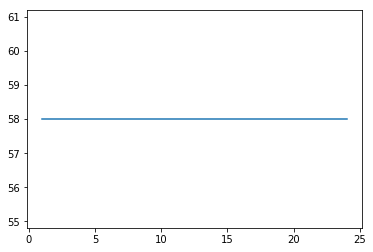

In [327]:
#Implementing LDA for geeting the most correlated pairs with the output class and then training LR model
l = range(1,25,1)
max_acc=0
best_l=0
acc_score_lbest=[]
for i in l:
    lda = LinearDiscriminantAnalysis(n_components=i)
    train_data_lda = lda.fit_transform(train_data_norm, train_label['Label'])
    test_data_lda = lda.transform(test_data_norm)

    #Logistic Regression using LDA features
    lr_lda = LogisticRegression(penalty='l2', C=1)
    lr_lda.fit(train_data_lda,train_label['Label'])
    pred_lr_lda = lr_lda.predict(test_data_lda)

    #Checking accuracy score
    acc = metrics.accuracy_score(test_label['Label'], pred_lr_lda)*100
    #print(acc)
    if acc>max_acc:
            max_acc=acc
            best_l=i
    acc_score_lbest.append(acc)
    
plt.plot(l,acc_score_lbest)
print('maximum accuracy of',max_acc,'is obtained for k=',best_l)

### Gradient Boosting

In [ ]:
parameters = {'learning_rate': [0.01],
              'max_depth': [15],
              'subsample': [0.8],
              'n_estimators': [600],
              'max_features': [6]
             }             

In [ ]:
#Implementing Baseline Gradient Boosting
gbm0 = GradientBoostingClassifier(random_state=0)
gbm0.fit(train_data,train_label['Label'])

gbm_pred = gbm0.predict(test_data)

gbm_acc = metrics.accuracy_score(test_label['Label'],gbm_pred)

gbm_acc

In [ ]:
n_features = 20
train_data_gbm = train_data.iloc[:,gbm0.feature_importances_.argsort()[::-1][:n_features]]
test_data_gbm = test_data.iloc[:,gbm0.feature_importances_.argsort()[::-1][:n_features]]

In [ ]:
cv_score=GridSearchCV(gbm0, parameters, refit=True, n_jobs=-1)

cv_score.fit(train_data_gbm, train_label['Label'])

cv_score.best_score_

In [ ]:
gbm_cv_pred = cv_score.predict(test_data_gbm)

acc_gbm_cv = metrics.accuracy_score(gbm_cv_pred,test_label['Label'])

acc_gbm_cv

In [ ]:
cv_score.best_params_

## Testing